In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import torch
from time import time
from fvcore.nn import FlopCountAnalysis
from src.models.lbcnn.axial_lbcnn import SmallAxialUNetLBC, AxialUNetLBC
from src.models.lbcnn.axial_unet import AxialUNet, SmallAxialUNet
from src.models.lbcnn.lbc_unet import UNetLBP, SmallUNetLBP
from src.models.unet.unet_model import UNet, SmallUNet
from src.models.dsc.dsc_lbc_unet import DSCSmallUNetLBP, DSCUNetLBP
from src.models.dsc.dsc_unet import UNetDSC
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, lraspp_mobilenet_v3_large

In [3]:
def load_json_metrics(file_path):
    with open(file_path, 'r') as fp:
        metrics = json.load(fp)
    return metrics

def plot_json(json_dict, name, ax):
    ax.plot(list(json_dict.keys()), list(json_dict.values()), label=name)
    
def get_mean_metric(metric_dict, from_epoch, to_epoch=None):
    df = pd.DataFrame.from_dict(metric_dict, orient='index')
    return df[from_epoch:to_epoch].mean().item()

def get_n_params(model, verbose=False):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    if verbose:
        print('Total Params: ', pytorch_total_params)

    params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            params += param.numel()
    if verbose:
        print('Trainable Params: ', params)
    return pytorch_total_params, params

### IoU Metrics

In [3]:
metric_of_interest = 'iou'

# UNet
unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/frosty_sponge_239_unet_ice-mean-{metric_of_interest}-epoch.json')

# Axial UNet
axial_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/fiery_blaze_231_full_axial_unet_ice_64_channels-mean-{metric_of_interest}-epoch-128-256-size.json')

# LBC UNet
lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/worthy_wood_227_lbc_unet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# Small Axial LBC UNet
small_axial_lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/glamorous_breeze_180_small_axial_unet_lbc_ice-mean-{metric_of_interest}-epoch.json')

# Deeplab MobileNet
deeplab_mobile_net = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/vivid_donkey_305_deeplab_mobilenet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# Deeplab MobileNet
lraspp_mobile_net = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/clean_darkness_312_laraspp_mobilenet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# DSC UNet
dsc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/helpful_fire_308_unet_dsc_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# DSC LBC UNet
dsc_lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/youthful_microwave_310_lbc_dsc_unet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# Small DSC LBC UNet
small_dsc_lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/still_paper_311_small_lbc_dsc_unet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')


metric_dicts = {
    'unet': unet, 
    'axial_unet': axial_unet,
    'lbc_unet': lbc_unet, 
    'small_axial_lbc_unet': small_axial_lbc_unet,
    'deeplab_mobile_net': deeplab_mobile_net,
    'lraspp_mobile_net': lraspp_mobile_net,
    'dsc_unet': dsc_unet,
    'dsc_lbc_unet': dsc_lbc_unet,
    'small_dsc_lbc_unet': small_dsc_lbc_unet,
}

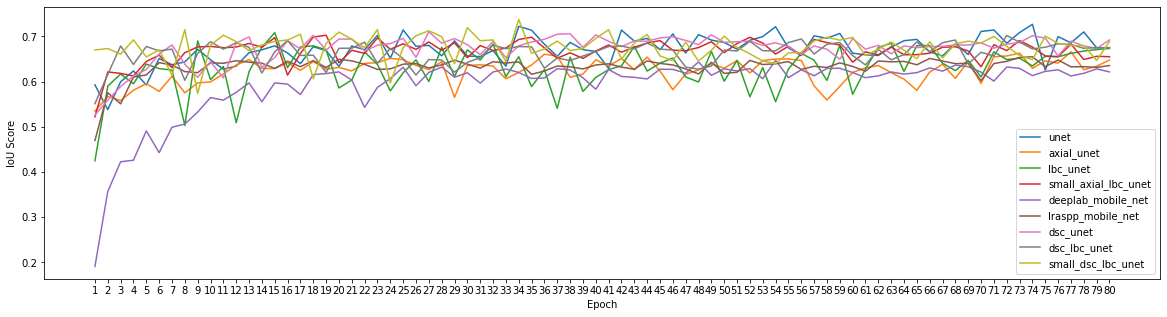

In [4]:
fig, ax = plt.subplots(figsize=(20,5))

ax.set_ylabel('IoU Score')
ax.set_xlabel('Epoch')
plot_json(unet, 'unet', ax)
plot_json(axial_unet, 'axial_unet', ax)
plot_json(lbc_unet, 'lbc_unet', ax)
plot_json(small_axial_lbc_unet, 'small_axial_lbc_unet', ax)
plot_json(deeplab_mobile_net, 'deeplab_mobile_net', ax)
plot_json(lraspp_mobile_net, 'lraspp_mobile_net', ax)
plot_json(dsc_unet, 'dsc_unet', ax)
plot_json(dsc_lbc_unet, 'dsc_lbc_unet', ax)
plot_json(small_dsc_lbc_unet, 'small_dsc_lbc_unet', ax)
plt.legend();
# ax.set_title('Full Size Comparison');

In [5]:
FROM_EPOCH = 20
avg_metric_dict = {}
for model in metric_dicts.keys():
    avg_metric_dict[model] = get_mean_metric(metric_dicts[model], FROM_EPOCH)

In [6]:
avg_metric_dict

{'unet': 0.682293904821078,
 'axial_unet': 0.6298791617155075,
 'lbc_unet': 0.6352974305550257,
 'small_axial_lbc_unet': 0.6720429321130117,
 'deeplab_mobile_net': 0.6175214439630509,
 'lraspp_mobile_net': 0.6361964911222457,
 'dsc_unet': 0.6831983198722203,
 'dsc_lbc_unet': 0.6656334926684697,
 'small_dsc_lbc_unet': 0.677533096075058}

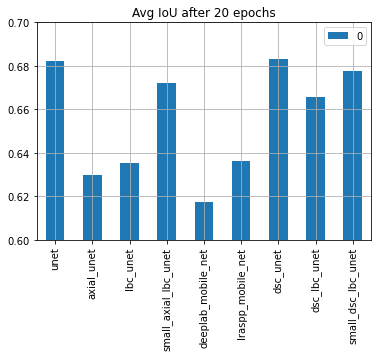

In [7]:
ax = pd.DataFrame.from_dict(avg_metric_dict, orient='index').plot.bar(ylim=(0.6, 0.70), title='Avg IoU after 20 epochs')
ax.grid();

### Model Parameters

In [4]:
unet_model = UNet(n_channels=3, n_classes=3, bilinear=True)
# axial_unet_model = AxialUNet(3, 3, 64)
lbc_unet_model = UNetLBP(3, 3)
small_axial_lbc_unet_model = SmallAxialUNetLBC(3, 3, 10)
deeplab_mobile_net_model = deeplabv3_mobilenet_v3_large(num_classes=3)
lraspp_mobile_net_model = lraspp_mobilenet_v3_large(num_classes=3)
dsc_unet_model = UNetDSC(n_channels=3, n_classes=3, bilinear=True)
dsc_lbc_unet_model = DSCUNetLBP(3, 3)
small_dsc_lbc_unet_model = DSCSmallUNetLBP(3, 3)

models_dict = {
    'unet': unet_model,
#     'axial_unet': axial_unet_model,
    'lbc_unet': lbc_unet_model,
    'small_axial_lbc_unet': small_axial_lbc_unet_model,
    'deeplab_mobile_net': deeplab_mobile_net_model,
    'lraspp_mobile_net': lraspp_mobile_net_model,
    'dsc_unet': dsc_unet_model,
    'dsc_lbc_unet': dsc_lbc_unet_model,
    'small_dsc_lbc_unet': small_dsc_lbc_unet_model,
}

In [9]:
model_tot_param_dict, model_train_param_dict = {}, {}
for model in models_dict.keys():
#     print(model, ': ')
    tot, train = get_n_params(models_dict[model])
    model_tot_param_dict[model] = tot
    model_train_param_dict[model] = train

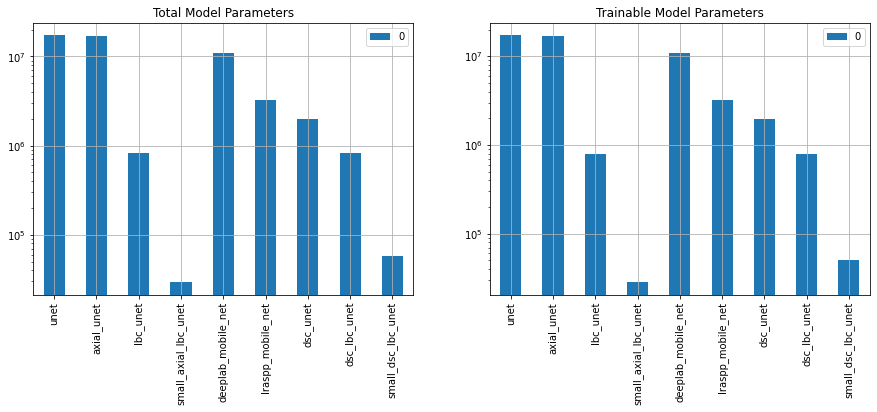

In [10]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
pd.DataFrame.from_dict(model_tot_param_dict, orient='index').plot.bar(ax=axs[0], title='Total Model Parameters', logy=True)
pd.DataFrame.from_dict(model_train_param_dict, orient='index').plot.bar(ax=axs[1], title='Trainable Model Parameters', logy=True)
axs[0].grid()
axs[1].grid();

### FLOPs

In [6]:
device = 'cpu'
inp = torch.rand(2,3,224,224).to(device)

model_flop_dict = {}
for model in models_dict.keys():
    flops = FlopCountAnalysis(models_dict[model].to(device), inp)
    model_flop_dict[model] = flops.total()/1000000

Unsupported operator aten::max_pool2d encountered 4 time(s)
Unsupported operator aten::sub encountered 16 time(s)
Unsupported operator aten::add_ encountered 10 time(s)
Unsupported operator aten::max_pool2d encountered 4 time(s)
Unsupported operator aten::sub encountered 16 time(s)
Unsupported operator aten::mul encountered 40 time(s)
Unsupported operator aten::softmax encountered 10 time(s)
Unsupported operator aten::add encountered 10 time(s)
Unsupported operator aten::max_pool2d encountered 2 time(s)
Unsupported operator aten::hardswish_ encountered 20 time(s)
Unsupported operator aten::add_ encountered 10 time(s)
Unsupported operator aten::hardsigmoid_ encountered 8 time(s)
Unsupported operator aten::mul encountered 8 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their sta

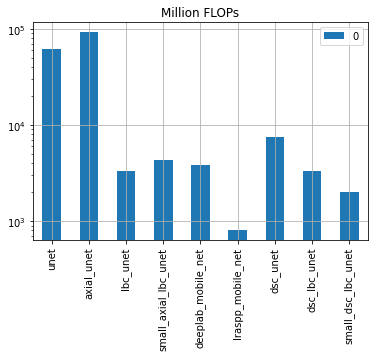

In [12]:
ax = pd.DataFrame.from_dict(model_flop_dict, orient='index').plot.bar(title='Million FLOPs', logy=True)
ax.grid();

### Run Time

In [6]:
def net_time_test(net, times, input_, mobile=False):
    backprop_duration = 0
    inference_duration = 0
    for i in range(times):
        if mobile:
            inference_start = time()
            out = net(input_)['out']
            inference_end = time()
        else:
            inference_start = time()
            out = net(input_)
            inference_end = time()
        backprop_start = time()
        out.backward(gradient=torch.randn(2, 3, 256, 256).to(device=device))
        backprop_end = time()
        backprop_duration += backprop_end - backprop_start
        inference_duration += inference_end - inference_start
    return backprop_duration, inference_duration

In [1]:
device = 'cuda'
iterations = 5
backprop_dict, inference_dict = {}, {}
input_ = torch.randn(2, 3, 256, 256).to(device=device)
for model in models_dict.keys():
    if 'mobile' in model:
        backprop_time, inference_time = net_time_test(models_dict[model].to(device), iterations, input_, mobile=True)
    else:
        backprop_time, inference_time = net_time_test(models_dict[model].to(device), iterations, input_, mobile=False)
    backprop_dict[model] = backprop_time
    inference_dict[model] = inference_time

fig, axs = plt.subplots(1,2, figsize=(15,5))
pd.DataFrame.from_dict(backprop_dict, orient='index').plot.bar(ax=axs[0], title='Backprop Time Cuda', logy=True)
pd.DataFrame.from_dict(inference_dict, orient='index').plot.bar(ax=axs[1], title='Inference Time Cuda', logy=True)
axs[0].grid()
axs[1].grid();

NameError: name 'torch' is not defined

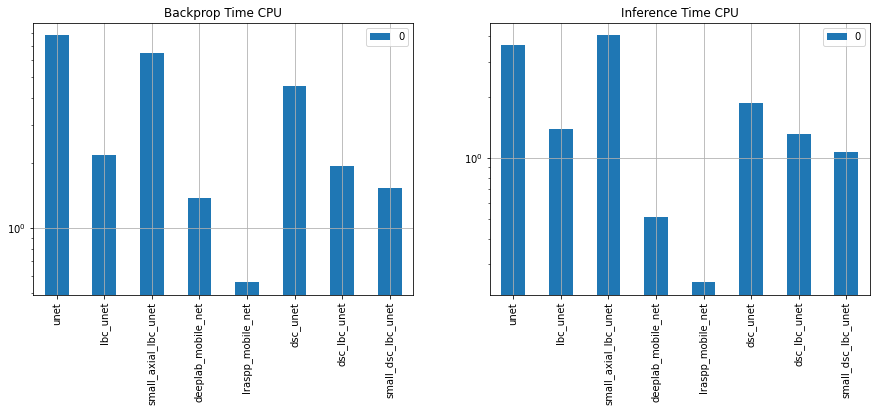

In [8]:
device = 'cpu'
iterations = 5
backprop_dict, inference_dict = {}, {}
input_ = torch.randn(2, 3, 256, 256).to(device=device)
for model in models_dict.keys():
    if 'mobile' in model:
        backprop_time, inference_time = net_time_test(models_dict[model].to(device), iterations, input_, mobile=True)
    else:
        backprop_time, inference_time = net_time_test(models_dict[model].to(device), iterations, input_)
    backprop_dict[model] = backprop_time
    inference_dict[model] = inference_time

fig, axs = plt.subplots(1,2, figsize=(15,5))
pd.DataFrame.from_dict(backprop_dict, orient='index').plot.bar(ax=axs[0], title='Backprop Time CPU', logy=True)
pd.DataFrame.from_dict(inference_dict, orient='index').plot.bar(ax=axs[1], title='Inference Time CPU', logy=True)
axs[0].grid()
axs[1].grid();